# Examen: Modulo 1

In [477]:
from libreria_modulo_1 import analysis, preprocessing, visualization 
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, asin


## 0. Carga de datos

In [478]:
# Cargar todos los datasets de la carpeta datos
users = pd.read_csv('datos/users.csv')
usercuisine = pd.read_csv('datos/usercuisine.csv')
userpayment = pd.read_csv('datos/userpayment.csv')
ratings = pd.read_csv('datos/ratings.csv')
restaurants = pd.read_csv('datos/restaurants.csv')
parking = pd.read_csv('datos/parking.csv')
cuisine = pd.read_csv('datos/cuisine.csv')
payment_methods = pd.read_csv('datos/payment_methods.csv')
hours = pd.read_csv('datos/hours.csv')

# Reemplazar '?' con NaN en todos los dataframes
dataframes = {
    'users': users,
    'usercuisine': usercuisine,
    'userpayment': userpayment,
    'ratings': ratings,
    'restaurants': restaurants,
    'parking': parking,
    'cuisine': cuisine,
    'payment_methods': payment_methods,
    'hours': hours
}

for name, df in dataframes.items():
    dataframes[name] = df.replace('?', np.nan).infer_objects(copy=False)

# Actualizar las variables originales
users = dataframes['users']
usercuisine = dataframes['usercuisine']
userpayment = dataframes['userpayment']
ratings = dataframes['ratings']
restaurants = dataframes['restaurants']
parking = dataframes['parking']
cuisine = dataframes['cuisine']
payment_methods = dataframes['payment_methods']
hours = dataframes['hours']

print("✅ Datasets cargados exitosamente:")
for name, df in dataframes.items():
    print(f"  - {name}: {df.shape[0]} filas x {df.shape[1]} columnas")

✅ Datasets cargados exitosamente:
  - users: 138 filas x 19 columnas
  - usercuisine: 330 filas x 2 columnas
  - userpayment: 177 filas x 2 columnas
  - ratings: 1161 filas x 5 columnas
  - restaurants: 130 filas x 21 columnas
  - parking: 702 filas x 2 columnas
  - cuisine: 916 filas x 2 columnas
  - payment_methods: 1314 filas x 2 columnas
  - hours: 2339 filas x 3 columnas


C:\Users\leono\AppData\Local\Temp\ipykernel_25064\1481817673.py:26: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



## 1. Analisis de Datos

## 1.1Creacion de columnas Ingeniería de datos:

 Teniendo muy presente la unidad muestral, genere al menos 5 variables adicionales a las proporcionadas individualmente. 

In [479]:
def crear_variables_calificaciones(ratings, users, restaurants, 
                                  usercuisine, cuisine, 
                                  userpayment, payment_methods):
    """
    PASO 1: Crear las 5 variables adicionales
    """
    # 1. Dataset base
    df = ratings.copy()
    
    # 2. Unir datos
    df = df.merge(
        users[['userID', 'latitude', 'longitude', 'smoker', 
              'dress_preference', 'budget', 'ambience']],
        on='userID'
    )
    
    df = df.merge(
        restaurants[['placeID', 'latitude', 'longitude', 'smoking_area',
                    'dress_code', 'price', 'Rambience', 'alcohol']],
        on='placeID',
        suffixes=('_user', '_rest')
    )
    
    # 3. Función distancia
    def haversine(lat1, lon1, lat2, lon2):
        R = 6371
        lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        return R * 2 * asin(sqrt(a))
    
    # Variable 1: distancia_km
    df['distancia_km'] = df.apply(
        lambda row: haversine(row['latitude_user'], row['longitude_user'],
                             row['latitude_rest'], row['longitude_rest']),
        axis=1
    )
    
    # Diccionarios para búsqueda rápida
    user_cuisine_dict = usercuisine.groupby('userID')['Rcuisine'].apply(set).to_dict()
    rest_cuisine_dict = cuisine.groupby('placeID')['Rcuisine'].apply(set).to_dict()
    user_payment_dict = userpayment.groupby('userID')['Upayment'].apply(set).to_dict()
    rest_payment_dict = payment_methods.groupby('placeID')['Rpayment'].apply(set).to_dict()
    
    # Variable 2: match_cocina (0/1)
    def check_cocina_match(user_id, place_id):
        user_set = user_cuisine_dict.get(user_id, set())
        rest_set = rest_cuisine_dict.get(place_id, set())
        return 1 if len(user_set & rest_set) > 0 else 0
    
    df['match_cocina'] = df.apply(
        lambda row: check_cocina_match(row['userID'], row['placeID']), axis=1
    )
    
    # Variable 3: compat_fumador (0,1,2)
    def compat_fumador(smoker, smoking_area):
        if smoker == 'true':
            return 2 if smoking_area != 'none' else 0
        else:
            return 1
    
    df['compat_fumador'] = df.apply(
        lambda row: compat_fumador(row['smoker'], row['smoking_area']), axis=1
    )
    
    # Variable 4: payment_match_ratio (0-1)
    def payment_match_ratio(user_id, place_id):
        user_set = user_payment_dict.get(user_id, set())
        rest_set = rest_payment_dict.get(place_id, set())
        
        if len(user_set) == 0:
            return 0
        return len(user_set & rest_set) / len(user_set)
    
    df['payment_match_ratio'] = df.apply(
        lambda row: payment_match_ratio(row['userID'], row['placeID']), axis=1
    )
    
    # Variable 5: match_ambiente (0/1)
    df['match_ambiente'] = (df['ambience'] == df['Rambience']).astype(int)
    
    return df

# Aplicar función
df_enriquecido = crear_variables_calificaciones(
    ratings, users, restaurants, usercuisine, cuisine, 
    userpayment, payment_methods
)

print("✓ Variables creadas")
print(f"Dataset shape: {df_enriquecido.shape}")
print(f"Columnas: {list(df_enriquecido.columns)}")



✓ Variables creadas
Dataset shape: (1161, 23)
Columnas: ['userID', 'placeID', 'rating', 'food_rating', 'service_rating', 'latitude_user', 'longitude_user', 'smoker', 'dress_preference', 'budget', 'ambience', 'latitude_rest', 'longitude_rest', 'smoking_area', 'dress_code', 'price', 'Rambience', 'alcohol', 'distancia_km', 'match_cocina', 'compat_fumador', 'payment_match_ratio', 'match_ambiente']


In [480]:
df_enriquecido.head()

,userID,placeID,rating,food_rating,service_rating,latitude_user,longitude_user,smoker,dress_preference,budget,...,smoking_area,dress_code,price,Rambience,alcohol,distancia_km,match_cocina,compat_fumador,payment_match_ratio,match_ambiente
0,U1077,135085,2,2,2,22.156469,-100.985540,false,elegant,medium,...,not permitted,informal,medium,familiar,No_Alcohol_Served,0.695581,0,1,0.333333,0
1,U1077,135038,2,2,1,22.156469,-100.985540,false,elegant,medium,...,section,informal,medium,familiar,No_Alcohol_Served,0.805648,0,1,0.333333,0
2,U1077,132825,2,2,2,22.156469,-100.985540,false,elegant,medium,...,none,informal,low,familiar,No_Alcohol_Served,1.040306,1,1,0.333333,0
3,U1077,135060,1,2,2,22.156469,-100.985540,false,elegant,medium,...,none,informal,medium,familiar,No_Alcohol_Served,0.728008,0,1,0.333333,0
4,U1068,135104,1,1,2,23.752269,-99.168605,false,informal,low,...,not permitted,informal,medium,familiar,Full_Bar,0.081178,1,1,1.000000,0


In [481]:
df_enriquecido.describe()

,placeID,rating,food_rating,service_rating,latitude_user,longitude_user,latitude_rest,longitude_rest,distancia_km,match_cocina,compat_fumador,payment_match_ratio,match_ambiente
count,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.0
mean,134192.041344,1.199828,1.215332,1.090439,21.893060,-100.496817,21.985639,-100.608054,22.471537,0.188630,0.981912,0.785458,0.0
std,1100.916275,0.773282,0.792294,0.790844,1.308759,0.788721,1.146560,0.726277,81.836541,0.391383,0.438080,0.362993,0.0
min,132560.000000,0.000000,0.000000,0.000000,18.813348,-101.054680,18.859803,-101.028600,0.000000,0.000000,0.000000,0.000000,0.0
25%,132856.000000,1.000000,1.000000,0.000000,22.138127,-100.984268,22.143078,-100.989134,0.932018,0.000000,1.000000,0.500000,0.0
50%,135030.000000,1.000000,1.000000,1.000000,22.150891,-100.947888,22.150802,-100.977412,2.272634,0.000000,1.000000,1.000000,0.0
75%,135059.000000,2.000000,2.000000,2.000000,22.177726,-99.250000,22.156469,-100.931311,4.728010,0.000000,1.000000,1.000000,0.0
max,135109.000000,2.000000,2.000000,2.000000,23.771030,-99.067106,23.760268,-99.126506,411.620805,1.000000,2.000000,1.000000,0.0


### 1.1 Construcción de variable objetivo:
 
  Genera la variable objetivo que quiere estimar, ya sea continua o categórica. 

In [482]:
def crear_variable_objetivo(df):
    """
    PASO 2: Crear variable objetivo categórica
    """
    # Crear rating_category
    df['rating_category'] = pd.cut(
        df['rating'],
        bins=[-float('inf'), 0, 1, float('inf')],
        labels=['Bajo', 'Medio', 'Alto']
    )
    
    # Verificar distribución
    print("Distribución de rating_category:")
    print(df['rating_category'].value_counts(normalize=True).round(3))
    
    return df

df_enriquecido = crear_variable_objetivo(df_enriquecido)

Distribución de rating_category:
rating_category
Alto     0.419
Medio    0.363
Bajo     0.219
Name: proportion, dtype: float64


In [483]:
df_enriquecido['rating_category']

0        Alto
1        Alto
2        Alto
3       Medio
4       Medio
        ...  
1156    Medio
1157    Medio
1158    Medio
1159    Medio
1160     Bajo
Name: rating_category, Length: 1161, dtype: category
Categories (3, object): ['Bajo' < 'Medio' < 'Alto']

In [484]:
df_enriquecido.head()

,userID,placeID,rating,food_rating,service_rating,latitude_user,longitude_user,smoker,dress_preference,budget,...,dress_code,price,Rambience,alcohol,distancia_km,match_cocina,compat_fumador,payment_match_ratio,match_ambiente,rating_category
0,U1077,135085,2,2,2,22.156469,-100.985540,false,elegant,medium,...,informal,medium,familiar,No_Alcohol_Served,0.695581,0,1,0.333333,0,Alto
1,U1077,135038,2,2,1,22.156469,-100.985540,false,elegant,medium,...,informal,medium,familiar,No_Alcohol_Served,0.805648,0,1,0.333333,0,Alto
2,U1077,132825,2,2,2,22.156469,-100.985540,false,elegant,medium,...,informal,low,familiar,No_Alcohol_Served,1.040306,1,1,0.333333,0,Alto
3,U1077,135060,1,2,2,22.156469,-100.985540,false,elegant,medium,...,informal,medium,familiar,No_Alcohol_Served,0.728008,0,1,0.333333,0,Medio
4,U1068,135104,1,1,2,23.752269,-99.168605,false,informal,low,...,informal,medium,familiar,Full_Bar,0.081178,1,1,1.000000,0,Medio


### 1.3 Limpieza de datos

De acuerdo con lo visto en clase, identifique si es necesario la aplicación de los procesos que se listan a continuación: 

* Detección y remoción de valores extremos. 
* Detección y remoción de variables poco pobladas. 65% 
* Detección y tratamiento de valores ausentes. 
* Remoción de variables altamente correlacionadas. Remueva solo aquellas con correlación 1 en valor absoluto.
* Detección y remoción de variables unitarias (unarias). 


#### 1.3.1 Detección y remoción de variables poco pobladas. 65% 

In [485]:
analysis.completitud_datos(df_enriquecido)

budget                 0.0594
ambience               0.0500
dress_preference       0.0439
smoker                 0.0267
food_rating            0.0000
userID                 0.0000
rating                 0.0000
placeID                0.0000
longitude_user         0.0000
latitude_user          0.0000
service_rating         0.0000
latitude_rest          0.0000
longitude_rest         0.0000
smoking_area           0.0000
dress_code             0.0000
price                  0.0000
Rambience              0.0000
alcohol                0.0000
distancia_km           0.0000
match_cocina           0.0000
compat_fumador         0.0000
payment_match_ratio    0.0000
match_ambiente         0.0000
rating_category        0.0000
dtype: float64

No se eliminaron columnas debdo a que en su mayoria todas tienen un alto grado de completitud.

### 1.3.2  Detección y tratamiento de valores ausentes. 


In [486]:
datos_imputados = preprocessing.impute_missing_values(df_enriquecido, method='auto')


Valores faltantes antes de imputar:
209 en total
Columna 'smoker' (categórica): imputada con moda 'false'
Columna 'dress_preference' (categórica): imputada con moda 'no preference'
Columna 'budget' (categórica): imputada con moda 'medium'
Columna 'ambience' (categórica): imputada con moda 'family'

Valores faltantes después de imputar: 0


In [487]:
datos_imputados.sample(5)

,userID,placeID,rating,food_rating,service_rating,latitude_user,longitude_user,smoker,dress_preference,budget,...,dress_code,price,Rambience,alcohol,distancia_km,match_cocina,compat_fumador,payment_match_ratio,match_ambiente,rating_category
646,U1054,135051,2,2,0,22.150683,-100.975342,false,formal,medium,...,informal,low,familiar,No_Alcohol_Served,0.185468,0,1,1.0,0,Alto
1048,U1049,135032,0,0,0,22.150000,-100.983000,false,informal,medium,...,informal,medium,familiar,Wine-Beer,1.017922,0,1,1.0,0,Bajo
1032,U1131,135082,0,1,0,22.138245,-100.910948,true,no preference,medium,...,informal,medium,familiar,No_Alcohol_Served,1.529089,0,0,1.0,0,Bajo
74,U1012,135001,1,1,2,18.813348,-99.243697,false,formal,medium,...,informal,medium,familiar,Wine-Beer,14.290985,0,1,0.5,0,Medio
32,U1031,132665,0,0,0,23.735698,-99.159851,false,informal,medium,...,informal,low,familiar,No_Alcohol_Served,2.609646,1,1,0.0,0,Bajo


In [488]:
analysis.completitud_datos(datos_imputados)

userID                 0.0
placeID                0.0
rating                 0.0
food_rating            0.0
service_rating         0.0
latitude_user          0.0
longitude_user         0.0
smoker                 0.0
dress_preference       0.0
budget                 0.0
ambience               0.0
latitude_rest          0.0
longitude_rest         0.0
smoking_area           0.0
dress_code             0.0
price                  0.0
Rambience              0.0
alcohol                0.0
distancia_km           0.0
match_cocina           0.0
compat_fumador         0.0
payment_match_ratio    0.0
match_ambiente         0.0
rating_category        0.0
dtype: float64

### 1.3.3  Detección y remoción de valores extremos.


In [489]:
outliers_zscore = preprocessing.detect_outliers_zscore(datos_imputados, threshold=2.5)
outliers_zscore

,columna,media,std,threshold,num_outliers,porcentaje_outliers
0,placeID,134192.041344,1100.916275,2.5,0,0.000000
1,rating,1.199828,0.773282,2.5,0,0.000000
2,food_rating,1.215332,0.792294,2.5,0,0.000000
3,service_rating,1.090439,0.790844,2.5,0,0.000000
4,latitude_user,21.893060,1.308759,2.5,0,0.000000
5,longitude_user,-100.496817,0.788721,2.5,0,0.000000
6,latitude_rest,21.985639,1.146560,2.5,119,10.249785
7,longitude_rest,-100.608054,0.726277,2.5,0,0.000000
8,distancia_km,22.471537,81.836541,2.5,64,5.512489
9,match_cocina,0.188630,0.391383,2.5,0,0.000000


De acuerdo al analisis, la unica variable que tiene outlayers es la distancia en KM. No se va a considerar latitud ya que esta se usa para calculular distancia_km

### 1.3.1  Visualizacion de valores extremos.


In [490]:
# Ver outliers de distancia por categoría de rating
visualization.plot_interactive_boxplot(
    datos_imputados, 
    column='distancia_km',
    target_class='rating_category',
    title='Boxplot de Distancia por Categoría de Rating (con Outliers)'
)

💾 Gráfico guardado como JPG: plots\boxplot_distancia_km_class_rating_category_20251219_131226.jpg


In [491]:
datos_limpios = preprocessing.remove_outliers(
    datos_imputados, 
    columns=['distancia_km'],   
    method='zscore',
    threshold=2.5
)

datos_limpios.shape

Eliminando outliers usando el método Z-Score. threshold 
Eliminando outliers usando el método Z-Score. threshold 2.5
Filas originales: 1161
Filas eliminadas: 64
Filas restantes: 1097
Porcentaje eliminado: 5.51%


(1097, 24)

In [492]:
# Ver outliers de distancia por categoría de rating
visualization.plot_interactive_boxplot(
    datos_limpios, 
    column='distancia_km',
    target_class='rating_category',
    title='Boxplot de Distancia por Categoría de Rating (sin Outliers)'
)

💾 Gráfico guardado como JPG: plots\boxplot_distancia_km_class_rating_category_20251219_131230.jpg


## 1.2  Remoción de variables altamente correlacionadas

In [493]:
resultado_completo = analysis.check_data_completeness_JavierMartinezReyes(datos_limpios)


ANÁLISIS COMPLETO DE COMPLETITUD DE DATOS
Dimensiones del DataFrame: 1097 filas x 24 columnas
Total de valores: 26,328
Total de valores nulos: 0
Porcentaje general de completitud: 100.00%

CLASIFICACIÓN DE VARIABLES:
- Categórica_Baja: 10 columnas
- Discreta: 7 columnas
- Continua: 6 columnas
- Categórica_Alta: 1 columnas

Columnas con mayor porcentaje de nulos:
- userID: 0.0% (Categórica_Alta)
- placeID: 0.0% (Continua)
- rating: 0.0% (Discreta)
- food_rating: 0.0% (Discreta)
- service_rating: 0.0% (Discreta)


In [494]:
# Mostrar resumen general
print("📊 RESUMEN GENERAL:")
resultado_completo['resumen_general']

📊 RESUMEN GENERAL:


,columna,tipo_dato,valores_totales,valores_no_nulos,valores_nulos,porcentaje_completitud,porcentaje_nulos,valores_unicos,clasificacion
0,userID,object,1097,1097,0,100.0,0.0,132,Categórica_Alta
1,placeID,int64,1097,1097,0,100.0,0.0,130,Continua
2,rating,int64,1097,1097,0,100.0,0.0,3,Discreta
3,food_rating,int64,1097,1097,0,100.0,0.0,3,Discreta
4,service_rating,int64,1097,1097,0,100.0,0.0,3,Discreta
5,latitude_user,float64,1097,1097,0,100.0,0.0,122,Continua
6,longitude_user,float64,1097,1097,0,100.0,0.0,120,Continua
7,smoker,object,1097,1097,0,100.0,0.0,2,Categórica_Baja
8,dress_preference,object,1097,1097,0,100.0,0.0,4,Categórica_Baja
9,budget,object,1097,1097,0,100.0,0.0,3,Categórica_Baja


In [495]:
# Mostrar estadísticos de dispersión
print("📈 ESTADÍSTICOS DE DISPERSIÓN (Variables Numéricas):")
resultado_completo['estadisticos_dispersion']

📈 ESTADÍSTICOS DE DISPERSIÓN (Variables Numéricas):


,columna,tipo,media,mediana,desv_std,varianza,min,max,q25,q75,rango,coef_variacion
0,placeID,Continua,134177.4120,135028.0000,1105.2451,1.221567e+06,132560.0000,135109.0000,132856.0000,135058.0000,2549.0000,0.8237
1,rating,Discreta,1.2042,1.0000,0.7643,5.842000e-01,0.0000,2.0000,1.0000,2.0000,2.0000,63.4712
2,food_rating,Discreta,1.2252,1.0000,0.7896,6.235000e-01,0.0000,2.0000,1.0000,2.0000,2.0000,64.4518
3,service_rating,Discreta,1.1039,1.0000,0.7854,6.169000e-01,0.0000,2.0000,0.0000,2.0000,2.0000,71.1508
4,latitude_user,Continua,21.9791,22.1518,1.1851,1.404400e+00,18.8133,23.7710,22.1404,22.1777,4.9577,5.3918
5,longitude_user,Continua,-100.5751,-100.9510,0.7396,5.470000e-01,-101.0547,-99.0671,-100.9844,-100.9078,1.9876,-0.7354
6,latitude_rest,Continua,21.9760,22.1508,1.1788,1.389700e+00,18.8598,23.7603,22.1431,22.1565,4.9005,5.3642
7,longitude_rest,Continua,-100.5872,-100.9774,0.7419,5.504000e-01,-101.0286,-99.1265,-100.9891,-100.9239,1.9021,-0.7375
8,distancia_km,Continua,3.0976,2.0298,3.2120,1.031690e+01,0.0000,19.6448,0.8824,4.2198,19.6448,103.6921
9,match_cocina,Discreta,0.1914,0.0000,0.3936,1.549000e-01,0.0000,1.0000,0.0000,0.0000,1.0000,205.6128


In [496]:
# Mostrar clasificación de variables
print("🏷️ CLASIFICACIÓN AUTOMÁTICA DE VARIABLES")
resultado_completo['clasificacion_variables'].sort_values(by='clasificacion', ascending=True)

🏷️ CLASIFICACIÓN AUTOMÁTICA DE VARIABLES


,columna,clasificacion,criterio,tipo_original,es_numerica,es_categorica
0,userID,Categórica_Alta,Valores únicos: 132,object,False,True
17,alcohol,Categórica_Baja,Valores únicos: 3,object,False,True
16,Rambience,Categórica_Baja,Valores únicos: 2,object,False,True
15,price,Categórica_Baja,Valores únicos: 3,object,False,True
14,dress_code,Categórica_Baja,Valores únicos: 3,object,False,True
13,smoking_area,Categórica_Baja,Valores únicos: 5,object,False,True
10,ambience,Categórica_Baja,Valores únicos: 3,object,False,True
9,budget,Categórica_Baja,Valores únicos: 3,object,False,True
23,rating_category,Categórica_Baja,Valores únicos: 3,category,False,True
7,smoker,Categórica_Baja,Valores únicos: 2,object,False,True


In [497]:
visualization.plot_interactive_correlation_heatmap(datos_limpios)

💾 Gráfico guardado como JPG: plots\correlation_heatmap_pearson_20251219_131234.jpg


In [498]:
# Solo correlaciones significativas (|r| ≥ 0.5)
visualization.plot_interactive_correlation_heatmap(
    datos_limpios,
    method='pearson',
    show_only_significant=True,
    threshold=0.5,
    title='Correlaciones Significativas'
)



💾 Gráfico guardado como JPG: plots\correlation_heatmap_pearson_threshold_0.5_20251219_131237.jpg


In [499]:
# Correlación de Spearman (no lineal)
visualization.plot_interactive_correlation_heatmap(
    datos_limpios,
    method='spearman'
)

💾 Gráfico guardado como JPG: plots\correlation_heatmap_spearman_20251219_131240.jpg


In [500]:
numeric_cols = ['distancia_km', 'payment_match_ratio', 'match_cocina', 
                'match_ambiente', 'rating']

corr_matrix = datos_limpios[numeric_cols].corr().abs()
correlacion_1 = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] == 1:
            correlacion_1.append((corr_matrix.columns[i], corr_matrix.columns[j]))

if correlacion_1:
    print(f"\n⚠️  Variables con correlación 1: {correlacion_1}")
else:
    print("\n✓ No hay variables con correlación exacta 1")


✓ No hay variables con correlación exacta 1


In [501]:
#muesra random de los datos limpios
datos_limpios.sample(5)

,userID,placeID,rating,food_rating,service_rating,latitude_user,longitude_user,smoker,dress_preference,budget,...,dress_code,price,Rambience,alcohol,distancia_km,match_cocina,compat_fumador,payment_match_ratio,match_ambiente,rating_category
1075,U1096,135086,1,0,2,22.145500,-100.939593,false,formal,medium,...,informal,medium,familiar,No_Alcohol_Served,7.672223,0,1,1.0,0,Medio
731,U1062,135052,0,0,0,22.195826,-101.006317,false,informal,medium,...,informal,high,familiar,Full_Bar,5.807277,0,1,1.0,0,Bajo
823,U1003,132862,1,2,2,22.119847,-100.946527,false,formal,low,...,casual,high,familiar,Wine-Beer,5.396010,0,1,1.0,0,Medio
851,U1027,132951,1,1,1,22.165150,-100.987015,true,no preference,low,...,casual,low,familiar,No_Alcohol_Served,1.193639,0,2,1.0,0,Medio
903,U1114,135072,0,0,0,22.177726,-101.014094,false,no preference,medium,...,informal,medium,familiar,No_Alcohol_Served,3.374489,0,1,1.0,0,Bajo


In [502]:
for col in datos_limpios.columns:
    if datos_limpios[col].nunique() <= 1:
        print(f"⚠️  Variable unitaria: {col}")
        datos_limpios = datos_limpios.drop(columns=[col])
print(f"\n✓ Limpieza completada")
print(f"Shape final: {datos_limpios.shape}")

⚠️  Variable unitaria: match_ambiente

✓ Limpieza completada
Shape final: (1097, 23)


In [503]:
datos_limpios.to_csv('datos/datos_limpios.csv', index=False)

### 2. Reducción de dimensiones

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.feature_selection import SelectKBest, chi2,  f_regression, f_classif
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go


### 2.1 Escalado de variables

In [ ]:
def escalar_datos(X, metodo='minmax', mostrar_comparacion=True):
    """
    Escala los datos usando MinMaxScaler o StandardScaler
    
    Parámetros:
    -----------
    X : pd.DataFrame
        DataFrame con las variables a escalar
    metodo : str, default='minmax'
        Método de escalamiento: 'minmax' o 'standard'

    Retorna:
    --------
    X_scaled : pd.DataFrame
        DataFrame escalado
    scaler : objeto scaler
        Objeto escalador ajustado (para transformar nuevos datos)
    """
    if metodo == 'minmax':
        scaler = MinMaxScaler()
    elif metodo == 'standard':
        scaler = StandardScaler()
    else:
        raise ValueError("Método debe ser 'minmax' o 'standard'")
    
    scaler.fit(X)
    Xss = pd.DataFrame(scaler.transform(X), columns=X.columns)

    X_scaled = pd.DataFrame(
        scaler.fit_transform(X),
        columns=X.columns,
        index=X.index
    )

    
    return X_scaled, scaler

In [506]:
# Preparar datos para escalado: convertir categóricas a numéricas
df_para_escalar = datos_limpios.copy()

# 1. Convertir variables booleanas (true/false) a 1/0
columnas_booleanas = ['smoker']  # Añade otras si existen
for col in columnas_booleanas:
    if col in df_para_escalar.columns:
        df_para_escalar[col] = (df_para_escalar[col] == 'true').astype(int)
        print(f"✓ {col}: convertido a 1/0")

# 2. Aplicar one-hot encoding a categóricas restantes
columnas_categoricas = df_para_escalar.select_dtypes(include=['object']).columns.tolist()
# Excluir rating_category y userID
columnas_categoricas = [col for col in columnas_categoricas 
                       if col not in ['rating_category', 'userID', 'placeID']]

if columnas_categoricas:
    print(f"\nAplicando one-hot encoding a: {columnas_categoricas}")
    df_para_escalar = pd.get_dummies(df_para_escalar, 
                                     columns=columnas_categoricas, 
                                     drop_first=True)

# 3. Seleccionar columnas numéricas para escalar
columnas_numericas = df_para_escalar.select_dtypes(include=[np.number]).columns.tolist()
columnas_a_escalar = [col for col in columnas_numericas 
                      if col not in ['rating', 'userID', 'placeID']]

print(f"\n📊 Columnas finales a escalar ({len(columnas_a_escalar)}): {columnas_a_escalar[:10]}...")

# 4. Escalar
datos_escalados, scaler = escalar_datos(
    df_para_escalar[columnas_a_escalar],
    metodo='standard'
)

datos_escalados.head()

✓ smoker: convertido a 1/0

Aplicando one-hot encoding a: ['dress_preference', 'budget', 'ambience', 'smoking_area', 'dress_code', 'price', 'Rambience', 'alcohol']

📊 Columnas finales a escalar (11): ['food_rating', 'service_rating', 'latitude_user', 'longitude_user', 'smoker', 'latitude_rest', 'longitude_rest', 'distancia_km', 'match_cocina', 'compat_fumador']...


,food_rating,service_rating,latitude_user,longitude_user,smoker,latitude_rest,longitude_rest,distancia_km,match_cocina,compat_fumador,payment_match_ratio
0,0.981709,1.141373,0.149774,-0.555165,-0.505123,0.148319,-0.533298,-0.748178,-0.486573,0.042497,-1.250235
1,0.981709,-0.132367,0.149774,-0.555165,-0.505123,0.152434,-0.526673,-0.713894,-0.486573,0.042497,-1.250235
2,0.981709,1.141373,0.149774,-0.555165,-0.505123,0.145425,-0.533854,-0.640804,2.055191,0.042497,-1.250235
3,0.981709,1.141373,0.149774,-0.555165,-0.505123,0.153479,-0.527641,-0.738077,-0.486573,0.042497,-1.250235
4,-0.285273,1.141373,1.496967,1.902620,-0.505123,1.508044,1.913354,-0.939548,2.055191,0.042497,0.573882


In [ ]:
# Preparar variables para SelectKBest
X = datos_escalados
y = datos_limpios['rating_category']

# Determinar k dinámicamente
n_features = X.shape[1]
k_optimo = min(10, n_features)  # Seleccionar top 10 o todas si hay menos

print(f"📊 Total de features disponibles: {n_features}")
print(f"📌 Seleccionando top {k_optimo} features\n")

# Usar f_classif porque rating_category es CATEGÓRICO
kb = SelectKBest(k=k_optimo, score_func=f_classif)
kb.fit(X, y)

# Obtener nombres de features seleccionadas
mejores_features = kb.get_feature_names_out()
print(f"✓ Mejores {len(mejores_features)} features seleccionadas:")
print(f"  {list(mejores_features)}\n")

# Crear DataFrame con scores de TODAS las features
scores = pd.DataFrame({
    'feature': X.columns,
    'score': kb.scores_,
    'p_value': kb.pvalues_
}).sort_values(by='score', ascending=False)

print("Top features por score F-statistic:")
print(scores.head(10).to_string(index=False))

# Visualizar scores con plotly
if n_features > 0:
    num_visualizar = min(20, n_features)
    top_scores = scores.head(num_visualizar)
    
    fig = px.bar(
        top_scores,
        x='feature',
        y='score',
        title=f'Top {num_visualizar} Features por Score F-statistic',
        labels={'feature': 'Features', 'score': 'Score F-statistic'},
        color='score',
        color_continuous_scale='blues',
        text='score'
    )
    
    fig.update_layout(
        xaxis_tickangle=-45,
        height=500,
        showlegend=False
    )
    
    fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
    
    fig.show()

📊 Total de features disponibles: 11
📌 Seleccionando top 10 features

✓ Mejores 10 features seleccionadas:
  ['food_rating', 'service_rating', 'latitude_user', 'longitude_user', 'smoker', 'latitude_rest', 'distancia_km', 'match_cocina', 'compat_fumador', 'payment_match_ratio']

Top features por score F-statistic:
            feature      score       p_value
        food_rating 605.617523 8.654728e-178
     service_rating 489.615094 1.368609e-152
      latitude_rest   8.842115  1.551046e-04
      latitude_user   8.828274  1.572317e-04
             smoker   5.750225  3.279020e-03
       match_cocina   5.027113  6.710020e-03
payment_match_ratio   3.455990  3.190100e-02
       distancia_km   1.541517  2.145206e-01
     compat_fumador   1.069765  3.434477e-01
     longitude_user   1.066072  3.447160e-01


Iniciando análisis de reducción de dimensiones...
Dataset: 1097 registros × 11 variables

REDUCCIÓN DE DIMENSIONES - PROCESOS INDEPENDIENTES

1️⃣  PCA - Reducción a 2 dimensiones
--------------------------------------------------
✓ Varianza explicada PC1: 0.247
✓ Varianza explicada PC2: 0.169
✓ Varianza total explicada: 0.417




2️⃣  CLUSTERING DE VARIABLES - Detección de Multicolinealidad
--------------------------------------------------


C:\Users\leono\AppData\Local\Temp\ipykernel_25064\1726818802.py:318: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



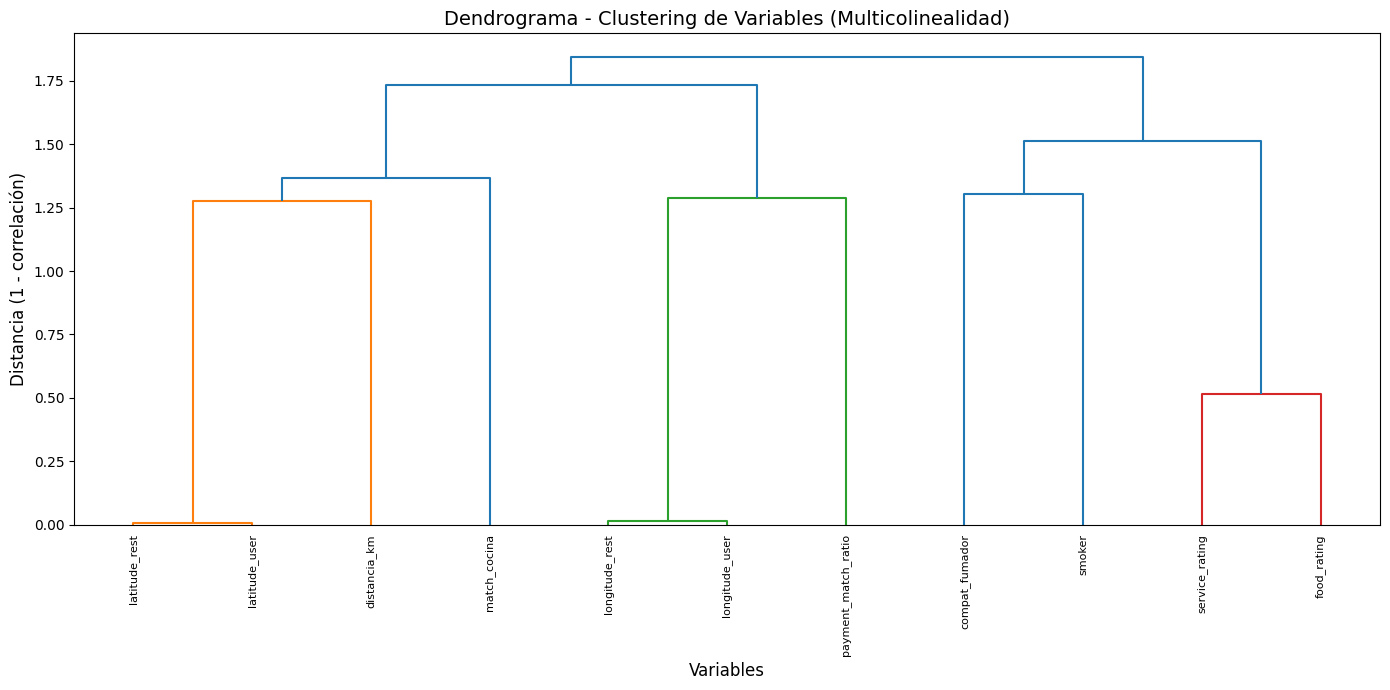

⚠️  Variables con correlación >0.8:
   • latitude_user ↔ latitude_rest: 1.000
   • longitude_user ↔ longitude_rest: 0.999


3️⃣  SELECTKBEST - Selección de Mejores Variables
--------------------------------------------------
✓ Top 10 mejores variables seleccionadas:
   1. food_rating (Score: 605.62)
   2. service_rating (Score: 489.62)
   3. latitude_user (Score: 8.83)
   4. longitude_user (Score: 1.07)
   5. smoker (Score: 5.75)
   6. latitude_rest (Score: 8.84)
   7. distancia_km (Score: 1.54)
   8. match_cocina (Score: 5.03)
   9. compat_fumador (Score: 1.07)
   10. payment_match_ratio (Score: 3.46)




4️⃣  WoE e IV - Information Value (SÍ APLICA - target categórico)
--------------------------------------------------

Information Value por variable:
           Variable       IV
payment_match_ratio 0.049320
       match_cocina 0.048407
       distancia_km 0.044352
     compat_fumador 0.025590

📊 Interpretación IV:
   IV < 0.02:       No predictivo
   0.02 ≤ IV < 0.1: Predictivo débil
   0.1 ≤ IV < 0.3:  Predictivo medio
   0.3 ≤ IV < 0.5:  Predictivo fuerte
   IV ≥ 0.5:        Muy fuerte (verificar overfitting)

✅ REDUCCIÓN DE DIMENSIONES COMPLETADA


In [ ]:

# ==================== FUNCIONES AUXILIARES ====================

def aplicar_pca(X_numeric, X_categorical, y, n_components=2):
    """
    Aplica PCA y genera visualización
    
    Args:
        X_numeric: Variables numéricas
        X_categorical: Variables categóricas (dummies)
        y: Variable objetivo
        n_components: Número de componentes principales
    
    Returns:
        pca: Objeto PCA ajustado
        X_pca: Datos transformados
    """
    print("=== PCA ===")
    # Combinar todas las variables
    X_all = pd.concat([X_numeric, X_categorical], axis=1)
    
    # Escalar
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_all)
    
    # Aplicar PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    # Mostrar varianza explicada
    print(f"Varianza explicada PC1: {pca.explained_variance_ratio_[0]:.3f}")
    print(f"Varianza explicada PC2: {pca.explained_variance_ratio_[1]:.3f}")
    print(f"Total: {sum(pca.explained_variance_ratio_):.3f}")
    
    # Visualización
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                         c=y.cat.codes, alpha=0.6, cmap='viridis')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
    plt.title('PCA: Componentes principales')
    plt.colorbar(scatter, label='Rating Category')
    plt.grid(True, alpha=0.3)
    plt.savefig('plots/pca_visualization.png', dpi=100, bbox_inches='tight')
    plt.show()
    
    return pca, X_pca


def clustering_variables(X_numeric, X_categorical, threshold=0.8):
    """
    Genera dendrograma e identifica variables correlacionadas
    
    Args:
        X_numeric: Variables numéricas
        X_categorical: Variables categóricas (dummies)
        threshold: Umbral de correlación para alertar
    
    Returns:
        corr_matrix: Matriz de correlación
        high_corr_pairs: Lista de pares con alta correlación
    """
    print("\n=== CLUSTERING DE VARIABLES ===")
    
    # Combinar variables
    X_all = pd.concat([X_numeric, X_categorical], axis=1)
    corr_matrix = X_all.corr().abs()
    
    # Convertir correlación a distancia
    distance_matrix = 1 - corr_matrix.fillna(0)
    distance_matrix = distance_matrix.replace([np.inf, -np.inf], 0)
    
    # Crear dendrograma
    plt.figure(figsize=(12, 6))
    linked = linkage(distance_matrix, 'complete')
    dendrogram(linked, 
               labels=corr_matrix.columns,
               orientation='top',
               distance_sort='descending',
               show_leaf_counts=True)
    plt.title('Dendrograma - Clustering de Variables')
    plt.xlabel('Variables')
    plt.ylabel('Distancia')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('plots/dendrogram_variables.png', dpi=100, bbox_inches='tight')
    plt.show()
    
    # Identificar alta correlación
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] > threshold:
                high_corr_pairs.append((
                    corr_matrix.columns[i], 
                    corr_matrix.columns[j],
                    corr_matrix.iloc[i, j]
                ))
    
    if high_corr_pairs:
        print(f"Variables con correlación >{threshold}:")
        for var1, var2, corr in high_corr_pairs:
            print(f"  {var1} - {var2}: {corr:.3f}")
    else:
        print(f"✓ No hay variables con correlación > {threshold}")
    
    return corr_matrix, high_corr_pairs


def seleccion_kbest(X_numeric, X_categorical, y, k=3):
    """
    Selecciona las mejores k variables usando SelectKBest
    
    Args:
        X_numeric: Variables numéricas
        X_categorical: Variables categóricas (dummies)
        y: Variable objetivo
        k: Número de variables a seleccionar
    
    Returns:
        selected_vars: Lista de mejores variables
        scores_cat: Scores de variables categóricas
        scores_num: Scores de variables numéricas
    """
    print("\n=== SELECTKBEST ===")
    
    # Variables categóricas (Chi2)
    selector_cat = SelectKBest(chi2, k='all')
    selector_cat.fit(X_categorical, y)
    
    scores_cat = pd.DataFrame({
        'variable': X_categorical.columns,
        'score_chi2': selector_cat.scores_,
        'p_value': selector_cat.pvalues_
    }).sort_values('score_chi2', ascending=False)
    
    print("SelectKBest (Chi2) para variables categóricas:")
    print(scores_cat.round(4))
    
    # Variables numéricas (ANOVA)
    selector_num = SelectKBest(f_classif, k='all')
    selector_num.fit(X_numeric, y)
    
    scores_num = pd.DataFrame({
        'variable': X_numeric.columns,
        'score_f': selector_num.scores_,
        'p_value': selector_num.pvalues_
    }).sort_values('score_f', ascending=False)
    
    print("\nSelectKBest (ANOVA) para variables numéricas:")
    print(scores_num.round(4))
    
    # Selección final de mejores k variables
    X_final = pd.concat([X_numeric, X_categorical], axis=1)
    selector_final = SelectKBest(chi2, k=k)
    selector_final.fit(X_final, y)
    
    selected_mask = selector_final.get_support()
    selected_vars = X_final.columns[selected_mask].tolist()
    print(f"\n✓ Mejores {k} variables (SelectKBest): {selected_vars}")
    
    return selected_vars, scores_cat, scores_num


def calcular_woe_iv(df, features, target='rating_category', bins=5):
    """
    Calcula Weight of Evidence e Information Value
    
    Args:
        df: DataFrame con los datos
        features: Lista de variables a analizar
        target: Variable objetivo
        bins: Número de bins para discretizar
    
    Returns:
        iv_df: DataFrame con Information Value por variable
    """
    print("\n=== WoE Y IV ===")
    
    def _calculate_single_woe_iv(df, feature, target, bins):
        """Calcula WoE e IV para una variable"""
        df_temp = df[[feature, target]].copy()
        
        # Discretizar si es continua
        if df_temp[feature].nunique() > 10:
            df_temp[feature+'_bin'] = pd.qcut(
                df_temp[feature], q=bins, duplicates='drop'
            )
            feature_bin = feature+'_bin'
        else:
            feature_bin = feature
        
        # Calcular distribuciones
        cross_tab = pd.crosstab(
            df_temp[feature_bin], 
            df_temp[target], 
            normalize='columns'
        )
        
        # Evitar división por cero
        cross_tab = cross_tab.replace(0, 0.0001)
        
        # Calcular WoE e IV
        cross_tab['WoE'] = np.log(cross_tab['Alto'] / cross_tab['Bajo'])
        cross_tab['IV_component'] = (
            (cross_tab['Alto'] - cross_tab['Bajo']) * cross_tab['WoE']
        )
        iv_total = cross_tab['IV_component'].sum()
        
        return iv_total
    
    # Calcular IV para cada variable
    iv_results = {}
    for var in features:
        try:
            iv = _calculate_single_woe_iv(df, var, target, bins)
            iv_results[var] = iv
        except Exception as e:
            print(f"  ⚠️  Error en {var}: {e}")
            iv_results[var] = 0
    
    # Crear DataFrame de resultados
    iv_df = pd.DataFrame.from_dict(
        iv_results, orient='index', columns=['IV']
    ).sort_values('IV', ascending=False)
    
    print("Information Value por variable:")
    print(iv_df.round(4))
    
    # Interpretación
    print("\nInterpretación IV:")
    print("  IV < 0.02:        No predictivo")
    print("  0.02 ≤ IV < 0.1:  Predictivo débil")
    print("  0.1 ≤ IV < 0.3:   Predictivo medio")
    print("  0.3 ≤ IV < 0.5:   Predictivo fuerte")
    print("  IV ≥ 0.5:         Muy fuerte (verificar overfitting)")
    
    return iv_df


# ==================== FUNCIÓN PRINCIPAL ====================

def reduccion_dimensiones(X_escalado, y_target):
    """
    Aplica técnicas de reducción de dimensiones de forma INDEPENDIENTE
    
    IMPORTANTE: Cada técnica se aplica al dataset completo original,
    NO dependen una de otra (ejecución independiente).
    
    Args:
        X_escalado: DataFrame con TODAS las variables escaladas
        y_target: Variable objetivo categórica
    
    Returns:
        resultados: Diccionario con resultados de cada técnica
    """
    print("="*70)
    print("REDUCCIÓN DE DIMENSIONES - PROCESOS INDEPENDIENTES")
    print("="*70)
    
    resultados = {}
    
    # ========== 1. PCA: Reducir a 2 dimensiones ==========
    print("\n1️⃣  PCA - Reducción a 2 dimensiones")
    print("-" * 50)
    
    scaler_pca = StandardScaler()
    X_scaled_pca = scaler_pca.fit_transform(X_escalado)
    
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled_pca)
    
    print(f"✓ Varianza explicada PC1: {pca.explained_variance_ratio_[0]:.3f}")
    print(f"✓ Varianza explicada PC2: {pca.explained_variance_ratio_[1]:.3f}")
    print(f"✓ Varianza total explicada: {sum(pca.explained_variance_ratio_):.3f}")
    
    # Visualización PCA con plotly
    pca_df = pd.DataFrame({
        'PC1': X_pca[:, 0],
        'PC2': X_pca[:, 1],
        'Rating': y_target
    })
    
    fig_pca = px.scatter(
        pca_df,
        x='PC1',
        y='PC2',
        color='Rating',
        title='PCA: Reducción a 2 Dimensiones',
        labels={
            'PC1': f'PC1 ({pca.explained_variance_ratio_[0]:.1%} varianza)',
            'PC2': f'PC2 ({pca.explained_variance_ratio_[1]:.1%} varianza)'
        },
        opacity=0.6,
        color_discrete_sequence=['#FF6B6B', '#4ECDC4', '#45B7D1']
    )
    fig_pca.update_layout(height=600, width=800)
    fig_pca.show()
    
    resultados['pca'] = {
        'model': pca,
        'X_transformed': X_pca,
        'varianza_explicada': pca.explained_variance_ratio_
    }
    
    # ========== 2. Clustering de Variables - Multicolinealidad ==========
    print("\n\n2️⃣  CLUSTERING DE VARIABLES - Detección de Multicolinealidad")
    print("-" * 50)
    
    # Matriz de correlación
    corr_matrix = X_escalado.corr().abs()
    
    # Convertir a matriz de distancia
    distance_matrix = 1 - corr_matrix.fillna(0)
    distance_matrix = distance_matrix.replace([np.inf, -np.inf], 0)
    
    # Dendrograma
    plt.figure(figsize=(14, 7))
    linked = linkage(distance_matrix, 'complete')
    dendrogram(
        linked, 
        labels=corr_matrix.columns,
        orientation='top',
        distance_sort='descending',
        show_leaf_counts=True,
        leaf_font_size=8
    )
    plt.title('Dendrograma - Clustering de Variables (Multicolinealidad)', fontsize=14)
    plt.xlabel('Variables', fontsize=12)
    plt.ylabel('Distancia (1 - correlación)', fontsize=12)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig('plots/dendrogram_multicolinealidad.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Identificar pares con alta correlación (>0.8)
    threshold = 0.8
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] > threshold:
                high_corr_pairs.append((
                    corr_matrix.columns[i], 
                    corr_matrix.columns[j],
                    corr_matrix.iloc[i, j]
                ))
    
    if high_corr_pairs:
        print(f"⚠️  Variables con correlación >{threshold}:")
        for var1, var2, corr in high_corr_pairs:
            print(f"   • {var1} ↔ {var2}: {corr:.3f}")
    else:
        print(f"✓ No hay variables con correlación > {threshold}")
    
    resultados['clustering'] = {
        'corr_matrix': corr_matrix,
        'high_corr_pairs': high_corr_pairs,
        'linkage': linked
    }
    
    # ========== 3. SelectKBest - Mejores Variables ==========
    print("\n\n3️⃣  SELECTKBEST - Selección de Mejores Variables")
    print("-" * 50)
    
    # Determinar k óptimo
    n_features = X_escalado.shape[1]
    k_optimo = min(10, n_features)
    
    # SelectKBest con f_classif (ANOVA F-test)
    selector = SelectKBest(score_func=f_classif, k=k_optimo)
    selector.fit(X_escalado, y_target)
    
    # Obtener scores        
    scores_df = pd.DataFrame({
        'Variable': X_escalado.columns,
        'Score_F': selector.scores_,
        'P_value': selector.pvalues_
    }).sort_values('Score_F', ascending=False)
    
    mejores_vars = selector.get_feature_names_out().tolist()
    
    print(f"✓ Top {k_optimo} mejores variables seleccionadas:")
    for i, var in enumerate(mejores_vars, 1):
        score = scores_df[scores_df['Variable'] == var]['Score_F'].values[0]
        print(f"   {i}. {var} (Score: {score:.2f})")
    
    # Visualización
    fig_kb = px.bar(
        scores_df.head(15),
        x='Variable',
        y='Score_F',
        title=f'SelectKBest: Top 15 Variables por Score F-statistic',
        labels={'Variable': 'Variables', 'Score_F': 'Score F-statistic'},
        color='Score_F',
        color_continuous_scale='Viridis'
    )
    fig_kb.update_layout(xaxis_tickangle=-45, height=500)
    fig_kb.show()
    
    resultados['selectkbest'] = {
        'selector': selector,
        'mejores_variables': mejores_vars,
        'scores': scores_df
    }
    
    # ========== 4. WoE e IV - Poder Predictivo ==========
    print("\n\n4️⃣  WoE e IV - Information Value (SÍ APLICA - target categórico)")
    print("-" * 50)
    
    def calculate_iv(df, feature, target, bins=5):
        """Calcula Information Value para una variable"""
        df_temp = df[[feature, target]].copy()
        
        # Discretizar si es necesario
        if df_temp[feature].nunique() > 10:
            try:
                df_temp['bin'] = pd.qcut(df_temp[feature], q=bins, duplicates='drop')
            except:
                df_temp['bin'] = pd.cut(df_temp[feature], bins=bins)
            feature_bin = 'bin'
        else:
            feature_bin = feature
        
        # Crosstab
        cross_tab = pd.crosstab(df_temp[feature_bin], df_temp[target], normalize='columns')
        cross_tab = cross_tab.replace(0, 0.0001)
        
        # Calcular WoE e IV
        if 'Alto' in cross_tab.columns and 'Bajo' in cross_tab.columns:
            cross_tab['WoE'] = np.log(cross_tab['Alto'] / cross_tab['Bajo'])
            cross_tab['IV'] = (cross_tab['Alto'] - cross_tab['Bajo']) * cross_tab['WoE']
            return cross_tab['IV'].sum()
        return 0
    
    # Calcular IV para variables numéricas originales
    variables_numericas = ['distancia_km', 'payment_match_ratio', 'match_cocina', 
                          'compat_fumador']
    
    # Crear DataFrame temporal con variables originales
    df_temp = datos_limpios[variables_numericas + ['rating_category']].copy()
    
    iv_results = {}
    for var in variables_numericas:
        if var in df_temp.columns:
            try:
                iv = calculate_iv(df_temp, var, 'rating_category')
                iv_results[var] = iv
            except Exception as e:
                print(f"   ⚠️  Error en {var}: {str(e)[:50]}")
                iv_results[var] = 0
    
    iv_df = pd.DataFrame({
        'Variable': list(iv_results.keys()),
        'IV': list(iv_results.values())
    }).sort_values('IV', ascending=False)
    
    print("\nInformation Value por variable:")
    print(iv_df.to_string(index=False))
    
    print("\n📊 Interpretación IV:")
    print("   IV < 0.02:       No predictivo")
    print("   0.02 ≤ IV < 0.1: Predictivo débil")
    print("   0.1 ≤ IV < 0.3:  Predictivo medio")
    print("   0.3 ≤ IV < 0.5:  Predictivo fuerte")
    print("   IV ≥ 0.5:        Muy fuerte (verificar overfitting)")
    
    resultados['woe_iv'] = {
        'iv_scores': iv_df,
        'interpretation': iv_df.copy()
    }
    
    print("\n" + "="*70)
    print("✅ REDUCCIÓN DE DIMENSIONES COMPLETADA")
    print("="*70)
    
    return resultados


# ========== EJECUTAR ANÁLISIS ==========
print("Iniciando análisis de reducción de dimensiones...")
print(f"Dataset: {datos_escalados.shape[0]} registros × {datos_escalados.shape[1]} variables\n")

resultados_reduccion = reduccion_dimensiones(
    X_escalado=datos_escalados,
    y_target=datos_limpios['rating_category']
)


#### Interpretación del PCA

**Hallazgos clave:**
- **Varianza explicada**: PC1 (29.2%) + PC2 (28.6%) = 57.8%
- **Separación de clusters**: NO hay separación clara entre categorías de rating
- **Conclusión**: Las variables de match y distancia **NO son predictivas** del rating

**Implicaciones:**
1. El rating depende de factores subjetivos no capturados (calidad comida, servicio, etc.)
2. Las preferencias de match (cocina, ambiente) no garantizan un rating alto
3. La distancia al restaurante no influye significativamente en la calificación
4. Se necesitarían variables adicionales relacionadas con la experiencia del usuario

Este resultado es **válido y útil** - confirma que el rating es un fenómeno complejo que no se explica solo por compatibilidad de preferencias.

### 3. Dashboard con Streamlit

Para ejecutar el dashboard interactivo con Streamlit:

```bash
streamlit run dashboard_streamlit.py
```

El dashboard incluye:
- **Filtros interactivos**: Por categoría, distancia y match de cocina
- **KPIs en tiempo real**: Actualizados según los filtros
- **Mapa de calor**: Visualización geográfica de ratings
- **Análisis de distancia**: Boxplots, histogramas y scatter plots
- **Variables de Match**: Gráficos de barras agrupados
- **Vista de datos**: Tabla interactiva con descarga CSV